In [16]:
# Import the libraries needed
import os
import joblib

import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.metrics import f1_score, make_scorer
from sklearn.metrics import classification_report

from sklearn.model_selection import cross_validate
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTENC, RandomOverSampler

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import IsolationForest

from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold, GridSearchCV, RandomizedSearchCV

import shap
from shap import LinearExplainer
import lime
from lime.lime_tabular import LimeTabularExplainer
from sklearn.inspection import permutation_importance

In [17]:
# Read the dataset from pickle file
current_path = os.getcwd()
X_train_log = pd.read_pickle(current_path + "/data/X_train_log.pkl")
y_train = pd.read_pickle(current_path + "/data/y_train.pkl")

X_train_log_aug = pd.read_pickle(current_path + "/data/X_train_log_aug.pkl")
y_train_log_aug = pd.read_pickle(current_path + "/data/y_train_log_aug.pkl")

X_test_log = pd.read_pickle(current_path + "\\data\\X_test_log.pkl")
y_test = pd.read_pickle(current_path + "\\data\\y_test.pkl")

Logistic Regression was already tested, and no further experiments will be performed on it as it is not of our interest

## Support Vector Classifier

We'll start by testing out Support vector classifier with different kernels.

In [3]:
# New oversampling approach with pipelines

# Use SMOTENC to oversample the sets used to perform cross-validation
cat_columns = [1, 3, 4, 5, 6, 7, 8, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
pipe = Pipeline([('resample', SMOTENC(cat_columns, k_neighbors=5, sampling_strategy="auto")), 
                       ('model', SVC(probability=True, random_state=42))])
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the parameters grid to be tested
kernel = ['rbf', 'linear', 'poly', 'sigmoid']
degree = [2, 3, 4, 5, 6]
C = [np.linspace(0.0, 1400.0, 14.0)
gamma = ['scale']
grid = dict(model__kernel=kernel, model__C=C, model__gamma=gamma, model__degree=degree)

# Use GridSearchCV to find the best parameters for the model
grid_search = GridSearchCV(estimator=pipe, param_grid=grid, cv=cv, scoring='f1', n_jobs=-1)
grid_results = grid_search.fit(X_train_log, y_train)

In [12]:
# Get the average scores and plot them
svc = grid_results.best_estimator_
params = grid_results.cv_results_['params']
results = pd.DataFrame(grid_search.cv_results_)
print(results)
#results.plot('param_model__kernel', ['mean_test_score', 'mean_train_score'])

# The best parameters found for SVC are: 
print('Best Parameters:', grid_results.best_params_)

   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0    1100.827068     18.010221        10.245993        0.740741   
1    1056.764915     13.769858        11.336517        0.514469   
2    1037.159964      5.658229        11.375195        0.230257   
3     809.601852    100.714281         8.465145        1.542963   
4     739.402359      7.697604         7.663129        0.550642   

  param_model__C param_model__gamma param_model__kernel  \
0           1400              scale                 rbf   
1           1300              scale                 rbf   
2           1200              scale                 rbf   
3           1100              scale                 rbf   
4           1000              scale                 rbf   

                                              params  split0_test_score  \
0  {'model__C': 1400, 'model__gamma': 'scale', 'm...           0.533133   
1  {'model__C': 1300, 'model__gamma': 'scale', 'm...           0.540323   
2  {'model__C': 1

In [3]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    print("fscore on test set: ", f1_score(y_test, y_pred, zero_division=True))
    print("confusion matrix:")
    confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
    cm_display.plot()
    plt.show()

              precision    recall  f1-score   support

           0       0.87      0.86      0.86      5873
           1       0.51      0.53      0.52      1627

    accuracy                           0.79      7500
   macro avg       0.69      0.69      0.69      7500
weighted avg       0.79      0.79      0.79      7500

fscore on test set:  0.5164008426120975
confusion matrix:


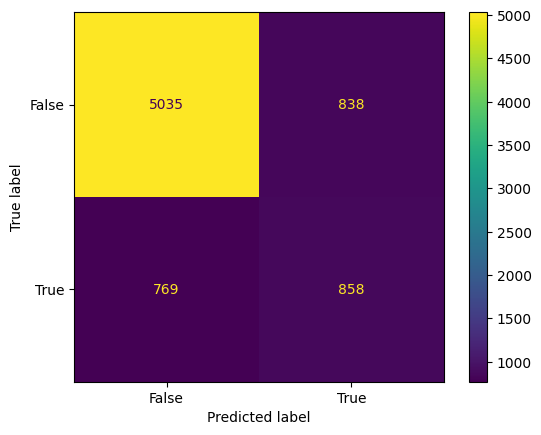

In [27]:
# Evaluate the SVC model
# svc = grid_results.best_estimator_
evaluate_model(svc, X_test_log, y_test)

With SVC with rbf as kernel and coefficient of linearization = 1300, we reached 0.516 of F1-score.

The f1 scoring function of GridSearchCV seem to give the accuracy instead of the f1-score for small grid sizes.

In [28]:
# Save the SVC model into a pkl file
joblib.dump(svc, current_path + "\\models\\svc_pipe.pkl")

['C:\\Users\\manue\\SUPSI\\Fifth Semester user\\Data Challenge\\project 2\\dc_3_project_2\\models\\svc_pipe.pkl']

In [4]:
# Read SVC model from pickle file
svc = joblib.load(current_path + "\\models\\svc_pipe.pkl")
svc

Pipeline(steps=[('resample',
                 SMOTENC(categorical_features=[1, 3, 4, 5, 6, 7, 8, 21, 22, 23,
                                               24, 25, 26, 27, 28, 29, 30,
                                               31])),
                ('model', SVC(C=1300, probability=True))])

X does not have valid feature names, but SVC was fitted with feature names


[('EDUCATION_5 <= 0.00', 0.3705225830106636), ('0.00 < EDUCATION_1 <= 1.00', -0.33597991262273513), ('EDUCATION_2 <= 0.00', 0.32848960883260697), ('EDUCATION_3 <= 0.00', 0.31405342456041613), ('EDUCATION_4 <= 0.00', 0.3116688053624982), ('EDUCATION_6 <= 0.00', 0.29821157929833586), ('MARRIAGE_3 <= 0.00', 0.2839646972738394), ('0.00 < MARRIAGE_2 <= 1.00', -0.22489109849570071), ('MARRIAGE_1 <= 0.00', 0.20311463555989312), ('EDUCATION_0 <= 0.00', 0.18717476314633416), ('MARRIAGE_0 <= 0.00', 0.09742497310723644), ('-1.00 < PAY_9 <= 0.00', -0.09125123367543754), ('BILL_AMT_9 > 0.12', -0.05130804627579156), ('-1.00 < PAY_8 <= 0.00', -0.04210874423209117), ('AGE <= 28.00', -0.034527766159964196), ('BILL_AMT_8 > 0.12', 0.021034826770265365), ('BILL_AMT_5 > 0.10', -0.01714650952970379), ('0.25 < LIMIT_BAL <= 0.39', -0.010451908848044344), ('-1.00 < PAY_5 <= 0.00', -0.009428688179384118), ('0.00 < PAY_AMT_4 <= 0.01', 0.00690934948080595), ('0.00 < PAY_AMT_9 <= 0.01', -0.006630591374080908), ('B

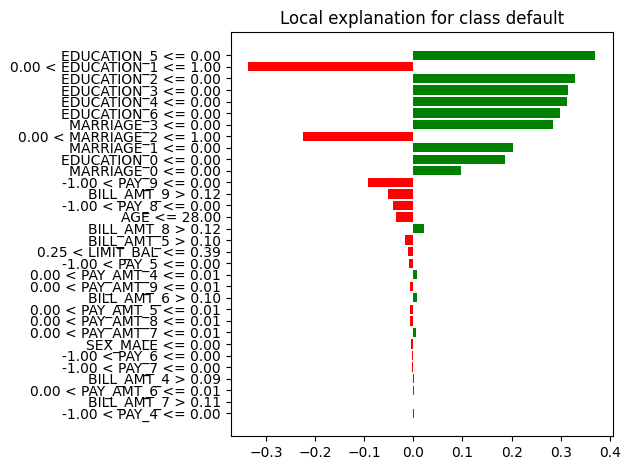

In [9]:
# Test LIME on SVC
svc_prob = svc
# Define the tabular lime explainer
explainer = LimeTabularExplainer(training_data=X_train_log.values,
    feature_names=X_train_log.columns,
    class_names=['did not default', 'default'],
    mode='classification')

# Try to explain a prediction on a sample
n_features = len(X_train_log.columns)
exp = explainer.explain_instance(predict_fn=svc_prob.predict_proba, data_row=X_test_log.iloc[1], num_features=n_features)

# Plot the Local explanation for class default
exp.as_pyplot_figure()
plt.tight_layout()
print(exp.as_list())

In [5]:
# Test SHAP on SVC
explainer = shap.KernelExplainer(svc_prob.predict_proba, shap.sample(X_train_log, 100), nsamples=100, link="logit")
shap_values = explainer.shap_values(shap.sample(X_test_log, 100))

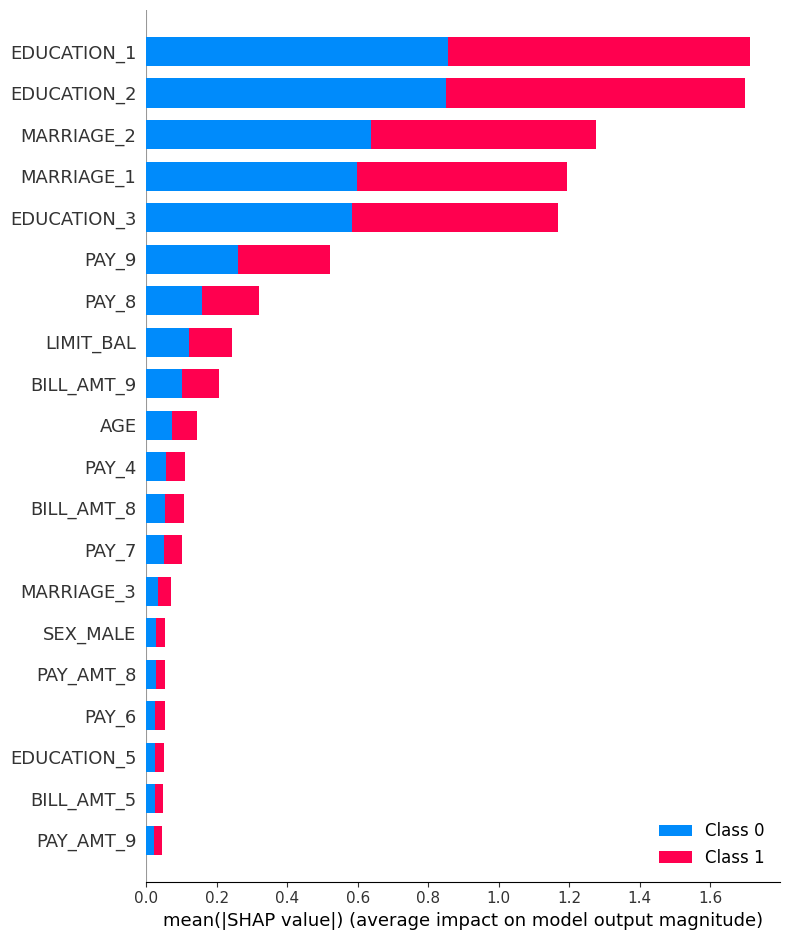

In [14]:
shap.summary_plot(shap_values, X_test_log)

In [ ]:
shap.summary_plot(shap_values, X_test_log, plot_type="violin")

In [8]:
# Compute Permutation Feature Importance on SVC
r = permutation_importance(svc, X_test_log, y_test, n_repeats=30, random_state=42)

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{X_train_log.columns[i]:<8}"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

EDUCATION_10.136 +/- 0.003
EDUCATION_20.136 +/- 0.004
MARRIAGE_20.134 +/- 0.003
MARRIAGE_10.120 +/- 0.003
PAY_9   0.076 +/- 0.003
EDUCATION_30.072 +/- 0.002
PAY_8   0.048 +/- 0.003
EDUCATION_50.008 +/- 0.001
MARRIAGE_30.005 +/- 0.001
EDUCATION_40.004 +/- 0.000
PAY_5   0.004 +/- 0.001
PAY_6   0.002 +/- 0.001
MARRIAGE_00.001 +/- 0.000
EDUCATION_60.001 +/- 0.000
EDUCATION_00.001 +/- 0.000


## Isolation Forest (Low performances/not working)

In [90]:
# Try to use an anomaly detection appproach to binary classification, identifying the minority class as anomalies.

# Use SMOTENC to oversample the sets used to perform cross-validation
cat_columns = [1, 3, 4, 5, 6, 7, 8, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
pipe = Pipeline([('resample', SMOTENC(cat_columns, k_neighbors=5, sampling_strategy="auto")), 
                       ('model', IsolationForest(random_state=42))])
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Set class 0 = -1 due to the anomaly detection rules
y_train_anomalies = [-1 if val==0 else 1 for val in y_train]
y_test_anomalies = [-1 if val==0 else 1 for val in y_test]

# Define the parameters grid to be tested
grid = {'model__n_estimators': [100, 300, 500, 700], 
        'model__max_samples': [100, 300, 500], 
        'model__contamination': [0.1, 0.3, 0.5], 
        'model__max_features': [5, 10, 15], 
        'model__bootstrap': [True, False], 
        'model__n_jobs': [-1]}

# Use GridSearchCV to find the best parameters for the model
scorer = make_scorer(f1_score, average = 'binary')  # 'binary' doesn't work for unknown reasons
grid_search_if = RandomizedSearchCV(estimator=pipe, param_distributions=grid, cv=cv, scoring=scorer, n_jobs=-1)
grid_results_if = grid_search_if.fit(X_train_log, y_train_anomalies)

X does not have valid feature names, but IsolationForest was fitted with feature names


In [91]:
# Get the average scores and plot them
is_forest = grid_results_if.best_estimator_
params = grid_results_if.cv_results_['params']
results = pd.DataFrame(grid_search_if.cv_results_)
print(results)
#results.plot('param_model__kernel', ['mean_test_score', 'mean_train_score'])

# The best parameters found for Isolation Forest are: 
print('Best Parameters:', grid_results_if.best_params_)

   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      30.674468      0.335632         2.352831        0.075300   
1      42.322709      0.270715         2.374414        0.083415   
2      36.989021      2.219799         2.870379        0.725183   
3      36.898678      1.628436         2.897169        0.558432   
4      40.540708      3.083155         5.114041        0.787686   
5      18.020330      0.446018         1.083982        0.155388   
6      37.405394      0.779027         4.493967        0.342757   
7      17.536149      0.708955         0.714339        0.085282   
8      25.542878      1.580821         1.595739        0.819780   
9      20.014287      1.283323         1.024578        0.420602   

  param_model__n_jobs param_model__n_estimators param_model__max_samples  \
0                  -1                       300                      100   
1                  -1                       700                      500   
2                  -1             

In [92]:
# Best F1 score reached
grid_results_if.best_score_

0.35697285902520826

              precision    recall  f1-score   support

          -1       0.81      0.12      0.21      5873
           1       0.22      0.90      0.35      1627

    accuracy                           0.29      7500
   macro avg       0.52      0.51      0.28      7500
weighted avg       0.68      0.29      0.24      7500

fscore on test set:  0.35450695704779195
confusion matrix:


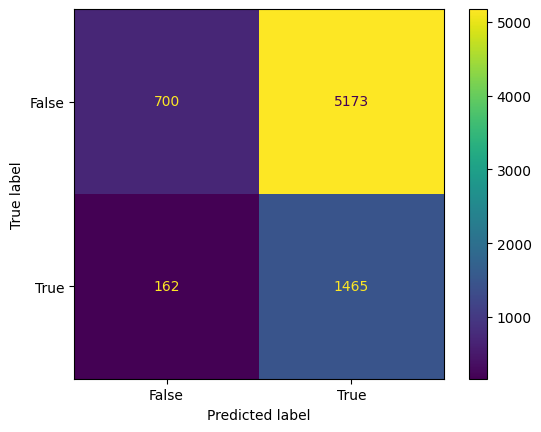

In [94]:
# Evaluate the Isolation Forest model
#is_forest = grid_results_if.best_estimator_
evaluate_model(is_forest, X_test_log, y_test_anomalies)

Using Isolation FOrest with the following parameters: 'model__n_jobs': -1, 'model__n_estimators': 300, 'model__max_samples': 100, 'model__max_features': 10, 'model__contamination': 0.1, 'model__bootstrap': True,

We reached 0.354 of F1-score, which is quite low.
We wanted to try an anomaly detection method applied to binary classification as sometimes it provides good results.

In [95]:
# Save the Isolation Forest pipeline into a pkl file
joblib.dump(is_forest, current_path + "\\models\\is_forest_pipe.pkl")

['C:\\Users\\manue\\SUPSI\\Fifth Semester user\\Data Challenge\\project 2\\dc_3_project_2\\models\\is_forest_pipe.pkl']

In [97]:
# Read Isolation Forest pipeline from pickle file
is_forest = joblib.load(current_path + "\\models\\is_forest_pipe.pkl")
is_forest

Pipeline(steps=[('resample',
                 SMOTENC(categorical_features=[1, 3, 4, 5, 6, 7, 8, 21, 22, 23,
                                               24, 25, 26, 27, 28, 29, 30,
                                               31])),
                ('model',
                 IsolationForest(bootstrap=True, contamination=0.1,
                                 max_features=10, max_samples=100,
                                 n_estimators=300, n_jobs=-1,
                                 random_state=42))])

In [103]:
# # Test LIME on Isolation Forest to check why it performs that bad

# # Define the tabular lime explainer
# explainer = LimeTabularExplainer(training_data=X_train_log.values,
#     feature_names=X_train_log.columns,
#     class_names=['did not default', 'default'],
#     mode='classification')

# # Try to explain a prediction on a sample
# n_features = len(X_train_log.columns)
# exp = explainer.explain_instance(predict_fn=is_forest.predict, data_row=X_test_log.iloc[1], num_features=n_features)

# # Plot the Local explanation for class default
# exp.as_pyplot_figure()
# plt.tight_layout()
# print(exp.as_list())

In [ ]:
# Test SHAP on Isolation Forest to check why it performs that bad
exp = shap.TreeExplainer(is_forest[1]) 
shap_values = exp.shap_values(X_test_log)

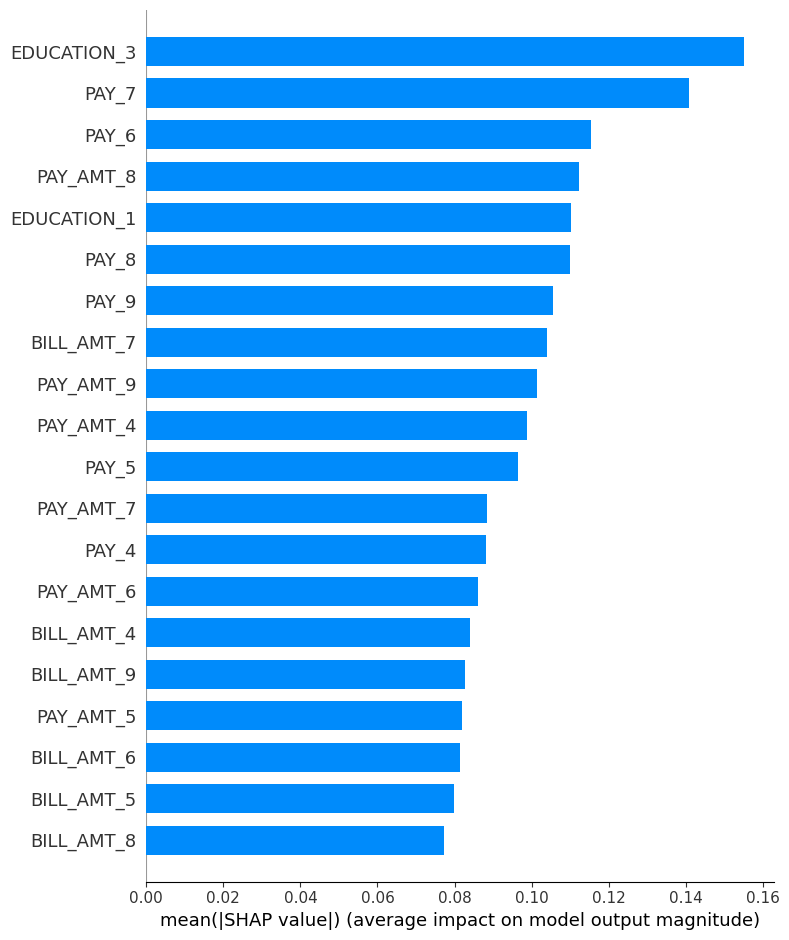

In [120]:
shap.summary_plot(shap_values, X_test_log.columns, plot_type="bar")

In [ ]:
# Compute Permutation Feature Importance on Isolation Forest to check why it performs that bad
r = permutation_importance(is_forest, X_test_log, y_test_anomalies, n_repeats=30, random_state=42, scoring='f1')

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{X_train_log.columns[i]:<8}"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")